from: http://shorturl.at/hrstz

In [1]:
!pip install george
!pip install emcee
!pip install corner

#Multiple time-series with time-delays

Consider a situation where we have several time-series, which we expect to display the same behaviour (up to observational noise), except for a time-delay. We don't know the form of the behaviour, but we want to measure the time-delay between each pair of time-series. Something like this might arise in [AGN reverberation mapping](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FReverberation_mapping), for example.

We can do this by modelling the time-series as observations of the same GP, with shifted inputs, and different realisations. We then marginalise over the GP hyper-parameters to obtain posterior distribution over the time shifts.

## Let's start simulating some data

In [2]:
import numpy as np
import george
import matplotlib.pylab as plt
from scipy.optimize import minimize
import corner

In [3]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

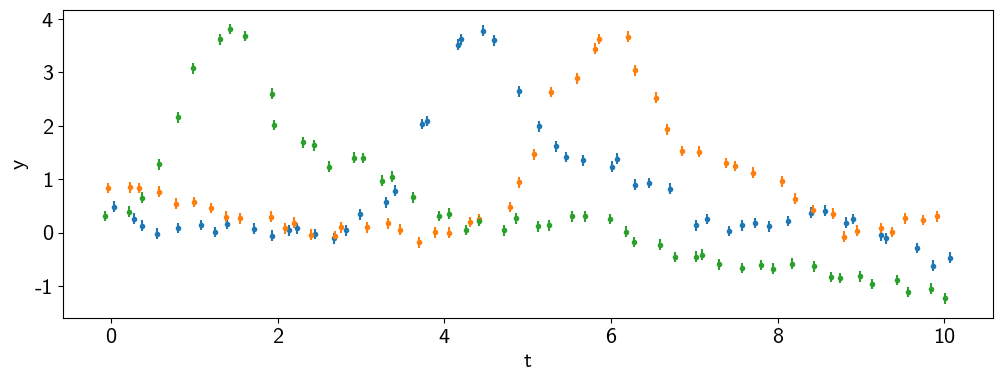

In [4]:
N = 50
M = 3
t2d = np.tile(np.linspace(0,10,N),(M,1))
for i in range(M):
    t2d[i,:] += np.random.uniform(-5./N,5./N,N)
delays_true = [-1.5,3]
t_delayed = np.copy(t2d)
for i in range(M-1):
    t_delayed[i+1,:] = t2d[i,:] + delays_true[i]
gp = george.GP(0.5 * george.kernels.Matern52Kernel(3.0))
gppar_true = gp.get_parameter_vector()
y2d = gp.sample(t_delayed.flatten()).reshape((M,N))
y2d += 3* np.exp(-(t_delayed-4.3)**2/2/0.5**2)
wn = 0.1
y2d += np.random.normal(0,wn,(M,N))
for i in range(M):
    plt.errorbar(t2d[i,:],y2d[i,:].flatten(),yerr=wn,capsize=0,fmt='.')
plt.xlabel('t')
plt.ylabel('y');

Because the function goes up an down, you can probably guess that the likelihood surface is going to be multi-modal. So it's important to have a decent initial guess for the time delays.

A simple way to do obtain one would be by cross-correlation. However, the time-series are not regularly sampled (because of the small random term we added to each of the time arrays), so we need to interpolate them onto a regular grid first. What better way to do this than with a GP? This will have the added advantage of giving us an initial estimate of the GP hyper-parameters too (we're assuming we don't know them either, though we will assume we know the white noise standard deviation).

## Model each time-series in turn using a Matern 3/2 kernel

Then, let's compute the mean of the predictive distribution over a tightly sampled, regular grid of time values.

True model GP HPs
[-0.69314718  1.09861229]
Individual GP fits: best-fit HPs
[[0.48514879 0.41943492]
 [0.33333307 0.17228643]
 [0.54165929 0.35574578]]
Initial guess GP HPs
[0.45338038 0.31582238]


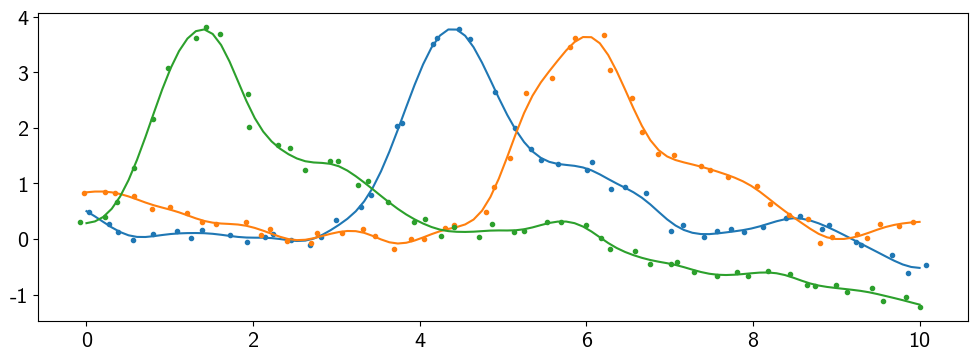

In [5]:
k = 1.0 * george.kernels.Matern52Kernel(3.0)
gp = george.GP(k)
p0 = gp.get_parameter_vector()
# 2-D array to hold the best-fit GP HPs for each time-series
p1 = np.tile(p0,(3,1))
# Regularly sampled time array
treg = np.linspace(0,10,100)
# 2-D array to hold the interpolated time-series
yreg = np.zeros((3,100))

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(zobs)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(zobs)

for i in range(M):
    # Compute the gp on the relevant subset of the 2-D time array t2d
    gp.compute(t2d[i,:].flatten(),yerr=wn)
    # Assign the corresponding y values to the variable zobs
    # (this is the one that neg_ln_like uses to condition the GP)
    zobs = y2d[i,:].flatten()
    # Optimize the likelihood using minimize
    result = minimize(neg_ln_like, p0, jac=grad_neg_ln_like)
    # Save the best-fit GP HPs in p1
    p1[i,:] = result.x
    # update the GP parameter vector with the best fit values
    gp.set_parameter_vector(result.x)
    # evaluate the predictive mean conditioned on zobs at locations treg and save in yreg
    yreg[i,:] = gp.predict(zobs,treg,return_var=False,return_cov=False)
    # you might want to plot the results to check it worked
    plt.plot(t2d[i,:],y2d[i,:],'C{}.'.format(i))
    plt.plot(treg,yreg[i,:],'C{}-'.format(i))
# And let's print the GP HPs to see if they were sensible.
print('True model GP HPs')
print(gppar_true)
print('Individual GP fits: best-fit HPs')
print(p1)
gppar_0 = np.mean(p1,axis=0)
print('Initial guess GP HPs')
print(gppar_0)

## Now cross-correlate the interpolated time-series

The easiest way to do this is using the function `xcorr` from `matplotlib.pyplot`. This function returns a tuple of 4 variables, the first two of which are the lags and corresponding cross-correlation values. Find the lag corresponding to the peak of the cross-correlation between each pair of time-series, and use that to make an initial guess as to the time-delays.

True delays
[-1.5, 3]
Initial guess delays from cross-correlation
[-1.51515152  3.03030303]


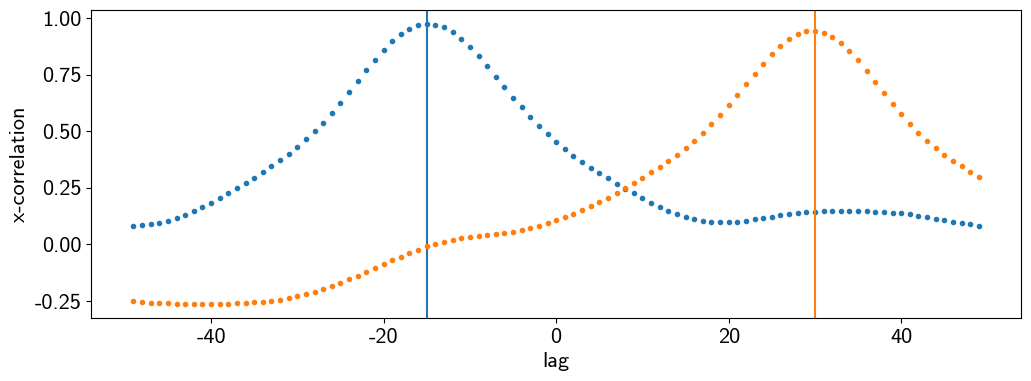

In [6]:
dt = treg[1] - treg[0]
# Array to hold estimates of the time-delays
delays_0 = np.zeros(M-1)
for i in range(M-1):
    # use pyplot's xcorr function to cross-correlate yreg[i+1] with yreg[0]
    lags, corr, _, _ = plt.xcorr(yreg[0,:],yreg[i+1,:],maxlags=49,usevlines=False,marker='.', color='C{}'.format(i))
    # find the lag that maximises the CCF, convert it to time delay, save in delays_0 array
    lmax = lags[np.argmax(corr)]
    plt.axvline(lmax,color='C{}'.format(i))
    delays_0[i] = dt * lmax
plt.xlabel('lag')
plt.ylabel('x-correlation');
# Compare estimated to true delays
print('True delays')
print(delays_true)
print('Initial guess delays from cross-correlation')
print(delays_0)

## Let's model the three time-series using a single GP, with time-delays

We now define a function `nll` to evaluate the negative log likelihood of the model, whose parameter array contains both the time delays, and the hyper-parameters of the GP, and use `minimize` to find the parameters that maximize the likelihood. You will probably find it useful to first define a function `apply_delays`, which will take the delays and the time array `t` as inputs, and return an $M \times N$ array of delayed times. It would also be useful for this function to warn us if the time-delays are such that one of the time-series no longer overlaps with the others at all, for example by returning a boolean variable that is true if all is well, but false if not.

In [7]:
def apply_delays(delays,t2d):
    t_delayed = np.copy(t2d)
    for i, delay in enumerate(delays):
        t_delayed[i+1,:] += delay
    ok = True
    M = len(delays) + 1
    for i in range(M):
        tc = t_delayed[i,:]
        to = t_delayed[np.arange(M)!=i,:]
        if (tc.min() > to.max()) + (tc.max() < to.min()):
            ok = False
    return t_delayed, ok

In [8]:
def neg_ln_like_delays(p):
    delays = p[:-2]
#    delays = p
    t_delayed, ok = apply_delays(delays,t2d)
    if not ok:
        return 1e25
    gp.set_parameter_vector(p[-2:])
    try:
      gp.compute(t_delayed.flatten(), yerr=wn)
      return -gp.log_likelihood(y2d.flatten())
    except:
      return 1e25

In [9]:
ptrue = np.concatenate([delays_true,gppar_true])
#ptrue = delays_true
p0 = np.concatenate([delays_0,gppar_0])
#p0 = delays_0
print('Initial guesses')
print(p0)
result = minimize(neg_ln_like_delays, p0)
p1 = np.array(result.x)
print('ML parameters')
print(p1)
print('True parameters')
print(ptrue)

Initial guesses
[-1.51515152  3.03030303  0.45338038  0.31582238]
ML parameters
[-1.51139569  3.00690051  0.27562307  0.49221994]
True parameters
[-1.5         3.         -0.69314718  1.09861229]


Now write a function `lnprob` to return the log posterior (it's fine to omit the priors, i.e. to use improper, open-ended uniform priors), then use `emcee` to explore the posterior. Plot the corner plot, labelled with the credible intervals of your choice.

In [10]:
def lnprob(p):
#    trange = t2d.max()-t2d.min()
#    if(abs(p[:-2])>trange).any():
#        return -np.inf
#    if(abs(p[-2:])>5).any():
#        return -np.inf
    return -neg_ln_like_delays(p)

In [11]:
# run MCMC
import emcee
nwalkers, ndim = 32, len(p1)
nsteps, nburn = 550, 50
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
pos = p1 + 1e-4 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, nsteps, progress=True);

100%|██████████| 550/550 [00:51<00:00, 10.73it/s]


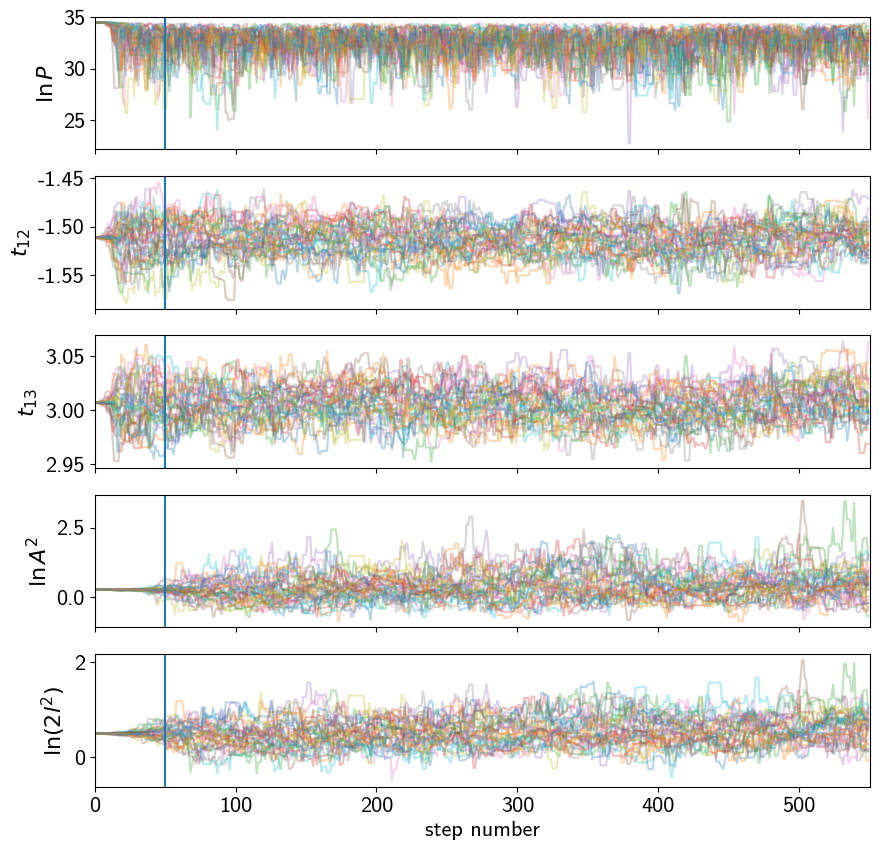

In [12]:
# always a good idea to check how the walkers behave
fig, axes = plt.subplots(ndim+1, figsize=(10, 10), sharex=True)
lnp = sampler.get_log_prob()
ax = axes[0]
ax.plot(lnp, "-", alpha=0.3)
ax.set_ylabel("$\ln P$")
ax.axvline(nburn)
samples = sampler.get_chain()
labels = ["$t_{12}$","$t_{13}$","$\ln A^2$","$\ln(2 l^2)$"]
#labels = ["$t_{12}$","$t_{13}$"]
for i in range(ndim):
    ax = axes[i+1]
    ax.plot(samples[:, :, i], "-", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.axvline(nburn)
axes[-1].set_xlabel("step number");


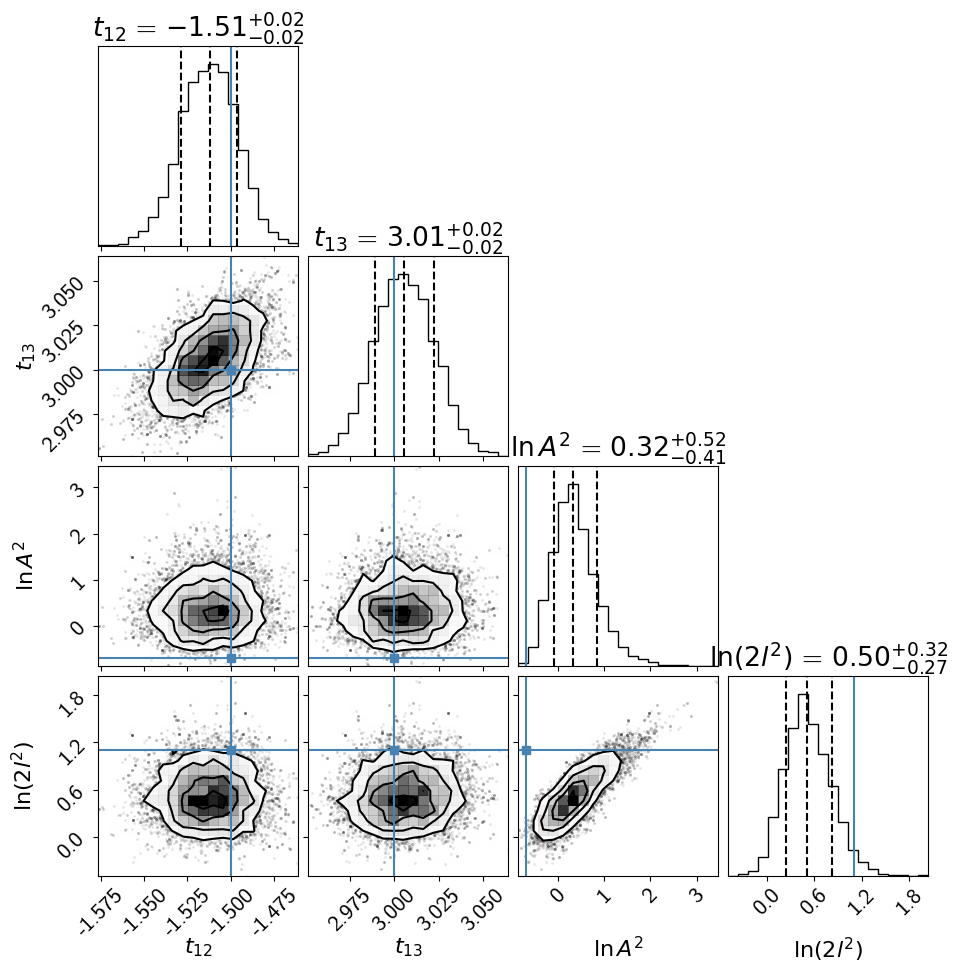

In [13]:
samples = sampler.get_chain(discard=nburn, flat=True)
fig = corner.corner(samples,labels=labels,quantiles=[0.16,0.5,.84],show_titles=True,truths=ptrue);

We can see that the uncertainties on the delays are smaller than the errors. This is to do with the limited time-sampling of the observations.